In [18]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/utils')
from evaluate import evaluate_clustering

import time
import tracemalloc

import SEDR

In [19]:
data_path = '/home/lytq/Spatial-Transcriptomics-Benchmark/data/BRCA1'
sample_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'

dir_input = os.path.join(data_path, sample_name)
dir_output = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/BRCA1/SEDR')
dir_output.mkdir(parents=True, exist_ok=True)

n_clusters = 20
device = 'cuda:4' if torch.cuda.is_available() else 'cpu'

In [20]:
time_start = time.time()
tracemalloc.start()

random_seed = 2025
SEDR.fix_seed(random_seed)

adata = sc.read_visium(dir_input)
adata.var_names_make_unique()

df_meta = pd.read_csv(os.path.join(dir_input, 'metadata.tsv'), sep='\t')
adata.obs['layer_guess'] = df_meta['fine_annot_type'].values

adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

graph_dict = SEDR.graph_construction(adata, 12)
    
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device=device)
using_dec = True
if using_dec:
    sedr_net.train_with_dec(N=1)
else:
    sedr_net.train_without_dec(N=1)
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

SEDR.mclust_R(adata, n_clusters, use_rep='SEDR', key_added='SEDR')
print('Clustering finished')

# Evaluate clustering
time_taken = time.time() - time_start
current, peak = tracemalloc.get_traced_memory()
memory_used = peak / (1024 ** 2)
tracemalloc.stop()

results = evaluate_clustering(adata, df_meta, time_taken, memory_used, dir_output, 
                              pred_key='SEDR', gt_df_key='fine_annot_type')
print(f'ARI = {results["ARI"]:.4f}')

100%|██████████| 200/200 [00:04<00:00, 40.02it/s]


fitting ...
  |======================================================================| 100%
Clustering finished
ARI = 0.4116


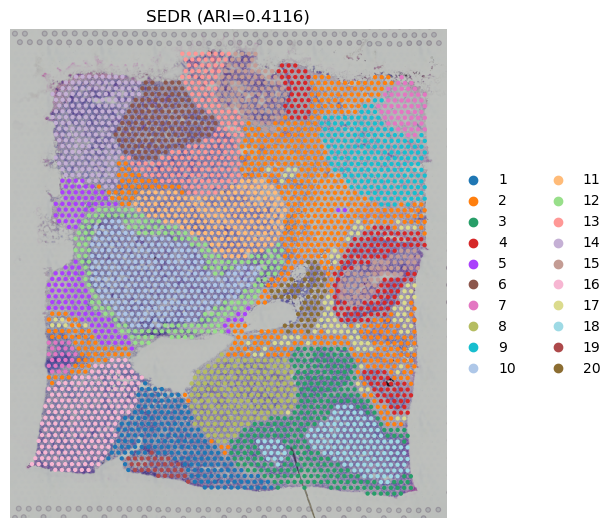

In [21]:
# Plot clustering
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='SEDR', ax=axes, show=False)
axes.set_title(f'SEDR (ARI={results["ARI"]:.4f})')
axes.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(dir_output, 'clustering.pdf'), dpi=300, bbox_inches='tight')

In [22]:
sc.pp.neighbors(adata, use_rep='SEDR', metric='cosine')
sc.tl.umap(adata)

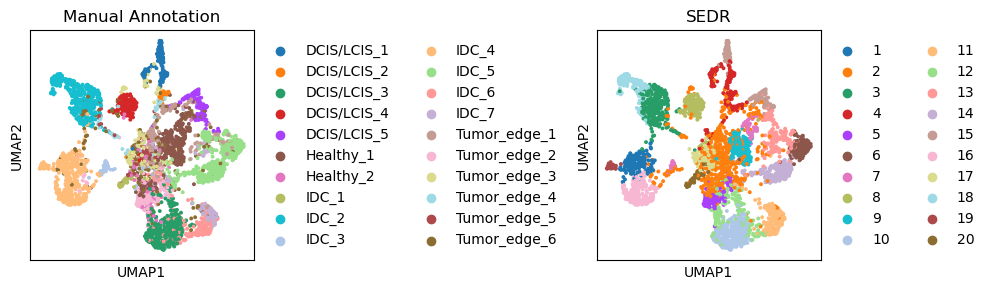

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sc.pl.umap(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.umap(adata, color='SEDR', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('SEDR')
plt.tight_layout()
plt.savefig(os.path.join(dir_output, 'umap.pdf'), format='pdf', dpi=300, bbox_inches='tight')

In [24]:
low_dim_data = pd.DataFrame(adata.obsm['SEDR'], index=adata.obs.index)
# expression_data = pd.DataFrame(adata.layers['count'], index=adata.obs.index, columns=adata.var.index)
cell_metadata = adata.obs

low_dim_data.to_csv(f"{dir_output}/low_dim_data.csv")
# expression_data.T.to_csv(f"{dir_out}/expression_matrix.csv")
cell_metadata.to_csv(f"{dir_output}/cell_metadata.csv")

umap_coords = adata.obsm["X_umap"]
spot_ids = adata.obs_names
umap_df = pd.DataFrame(umap_coords, columns=["UMAP1", "UMAP2"])
umap_df["spot_id"] = spot_ids
umap_df = umap_df[["spot_id", "UMAP1", "UMAP2"]]
umap_df.to_csv(os.path.join(dir_output, "spatial_umap_coords.csv"), index=False)
